In [1]:
import os
import sys
import shutil
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.rc('font', size=12.0)

import tensorflow as tf
from keras import layers, mixed_precision, regularizers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

2024-11-12 18:00:00.933827: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 18:00:00.936083: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 18:00:00.942370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731452400.952436  654876 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731452400.955373  654876 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 18:00:00.967034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
model = ['nl']
label = ['NL']
x_names = ['a', 'alpha', 'param_S', 'param_L', '', 'trans1',
           '', 'trans2', '', 'M_chirp_det', 'q', 'z_cdf']
for k in range(len(model)):
    if model[k] == 'mp' or model[k] == 'np':
        x_names[4], x_names[6], x_names[8] = 'exp1', 'exp2', 'exp3'
    else:
        x_names[4], x_names[6], x_names[8] = 'csq1', 'csq2', 'csq3'
y_names = ['I1', 'I2']

# Define file directory and load data
dir = '/home/anik/bamr/out/aff_inv/'
mchain = h5py.File(dir + 'nl_all', 'r')['markov_chain_0']

# Prepare X, Y, Z based on loaded data
x_ncols, y_ncols = len(x_names), len(y_names)
nrows, data = mchain['nlines'][0], mchain['data']
X, Y = np.zeros((x_ncols, nrows)), np.zeros((y_ncols, nrows))

for i in range(x_ncols):
    X[i] = data[x_names[i]]
for i in range(y_ncols):
    Y[i] = data[y_names[i]]

# Transpose X and Y to shape (nrows, ncols)
X, Y = X.T, Y.T

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

# Fit-transform X
x = scaler_X.fit_transform(X)
y = scaler_Y.fit_transform(Y)

# Split the data for training and validation as required
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=42)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_ts, y_ts, test_size=0.01, random_state=42)

In [3]:
tuner_dir = 'trials'

if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

In [4]:
# Define the DNN model with hyperparameter tuning
class DNNHyperModel(kt.HyperModel):
    def build(self, hp):
        model = tf.keras.Sequential()
        
        model.add(layers.Input(shape=(x_ncols,)))
        num_layers = hp.Int('num_layers', 1, 3)

        for i in range(num_layers):
            units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)
            model.add(layers.Dense(units, activation='relu'))

        model.add(layers.Dense(2, activation='linear'))
        model.compile(optimizer='adam', loss='mse')
        
        return model

# Set up the tuner for a random search
tuner = kt.RandomSearch(
    DNNHyperModel(),  # Use the defined hypermodel
    objective='val_loss',
    max_trials=100,
    executions_per_trial=1,
    directory='trials',
)

# Set up early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1.0e-6, 
    patience=10
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6
)

# Print the summary of search space
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}


W0000 00:00:1731452402.432448  654876 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
# Run search with variable batch sizes
tuner.search(
    x_tr, y_tr,
    epochs=200,
    validation_data=(x_ts, y_ts),
    batch_size=128,
    callbacks=[early_stop]
)

Trial 100 Complete [00h 00m 06s]
val_loss: 0.00019703352882061154

Best val_loss So Far: 2.3427368432749063e-05
Total elapsed time: 00h 11m 22s


In [20]:
tuner.results_summary(num_trials=5)

Results summary
Results in trials/untitled_project
Showing 5 best trials
Objective(name="val_loss", direction="min")

Trial 016 summary
Hyperparameters:
num_layers: 3
units_0: 224
units_1: 224
units_2: 192
Score: 2.3427368432749063e-05

Trial 022 summary
Hyperparameters:
num_layers: 2
units_0: 32
units_1: 192
units_2: 32
Score: 2.3743214114801958e-05

Trial 070 summary
Hyperparameters:
num_layers: 2
units_0: 160
units_1: 192
units_2: 96
Score: 2.4108047000481747e-05

Trial 015 summary
Hyperparameters:
num_layers: 3
units_0: 192
units_1: 64
units_2: 192
Score: 2.514718107704539e-05

Trial 040 summary
Hyperparameters:
num_layers: 3
units_0: 64
units_1: 32
units_2: 160
Score: 2.5459557946305722e-05


In [21]:
# Retrieve the best model and evaluate
best_hps = tuner.get_best_hyperparameters(num_trials=5)[1]
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 192)            │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,138 (27.88 KB)

 Trainable params: 7,138 (27.88 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', \
                                              min_delta=1.0e-6, patience=10)

# Optionally, retrain on the full dataset with optimal hyperparameters
training = best_model.fit(x_tr, y_tr, epochs=1000, validation_data=(x_ts, y_ts), \
                          batch_size=128, callbacks=[stop_early, lr_schedule])

Epoch 1/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0447 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 2/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 0.0054 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 3/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 0.0028 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 4/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 0.0016 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 5/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 9.9345e-04 - val_loss: 7.2189e-04 - learning_rate: 0.0010
Epoch 6/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 6.1429e-04 - val_loss: 5.1903e-04 - learning_rate: 0.0010
Epoch 7/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 5.1575e-04 - val_loss: 4.1038e-04 - learning_rate: 0.0010
Epoch 8/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 4.1443e-04 - val_loss: 3.7838e-04 - learning_rate: 0.0010
Epoch 9/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 3.5915e-04 -

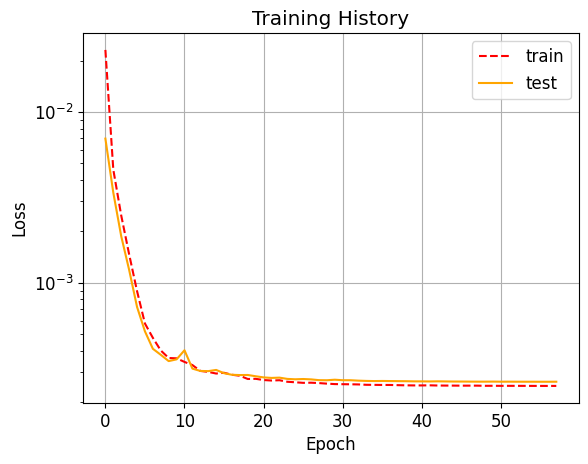

In [23]:
plt.semilogy(training.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


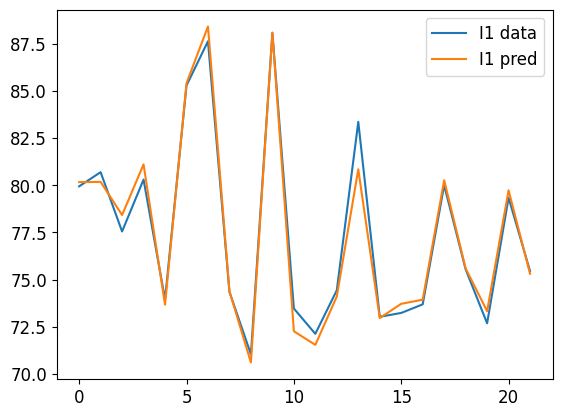

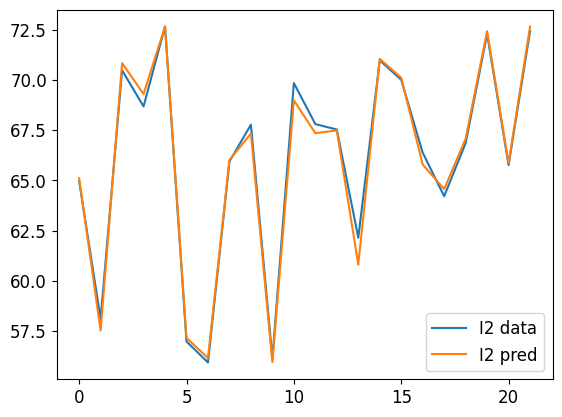

In [24]:
# Assume y_pr contains the normalized predictions and y_vl is the validation data
y_pr = best_model.predict(x_vl)

# Initialize arrays to store denormalized values
Y_pr = scaler_Y.inverse_transform(y_pr)
Y_vl = scaler_Y.inverse_transform(y_vl)

# Plot the results
plt.plot(Y_vl[:, 0], label='I1 data')
plt.plot(Y_pr[:, 0], label='I1 pred')
plt.legend()
plt.show()

plt.plot(Y_vl[:, 1], label='I2 data')
plt.plot(Y_pr[:, 1], label='I2 pred')
plt.legend()
plt.show()
